# Teleseismic *P*-wave coda autocorrelation

Thanh-Son Pham (ThanhSon.Pham@anu.edu.au) 

- October 2017: First release on [GitHub](https://github.com/tsonpham/PCodaAutocorrelation.git).
- March 2025: Revision for Observational Seismology Workshop at VNU Hanoi University of Science.

This notebook implements a lightweight version of the *P wave coda autocorrelation* method in the Python programing language. We demonstrate the method with seismic data retreived from the IRIS Data Center for station [YT ST01](https://ds.iris.edu/mda/YT/ST01/?starttime=2010-01-27T00:00:00&endtime=2012-12-31T23:59:59) deployed from 2010 to 2012 over the ~3 km thick icesheet in West Antarctica.

For more information, we refer to the following articles:
- Phạm T.-S. and H. Tkalčić, *On the feasibility and use of teleseismic P-wave coda autocorrelation for mapping shallow seismic discontinuities*, J. Geophys. Res.: Solid Earth, 122, doi:10.1002/2017JB013975, **2017**.
- Phạm T.-S. and H. Tkalčić, *Antarctic ice properties revealed from teleseismic P wave coda autocorrelation*, J. Geophys. Res.: Solid Earth, 123, doi:10.1029/2018JB016115, **2018**.

### Overview

### Spectral normalization
We use an adaptive weighting function to normalize the complex spectrum of the input waveform before computing the autocorrelation function. The spectral whitening is defined in a similar way to the running-absolute-mean normalization [Bensen et al., 2007] in the time domain as

\begin{equation}
\hat{s}_n = \frac{s_n} {\frac{1}{2N + 1} \sum_{j=n-N}^{n+N} |s_j|}.
\end{equation}

The number of averaging points $N$ in the denominator is alternatively refered as spectral whitening width $\Delta W = 2 N \Delta \omega$, where $\Delta \omega$ is the discrete frequency step $\Delta \omega = 1/L$ and $L$ is the length of the input time trace. Tuning the whitening width $\Delta W$ may change the performance of the method. We recommend to do experiments with this parameter to find an optimal value for your application.

In [1]:
import numpy as np
from scipy.signal import fftconvolve, hilbert

def smooth_avg(arr, winlen):
    """
    Smoothing a time series by averaging its values in a moving window. This averaging 
    window operation can be done efficiently with an convolution in the frequency domain.
    """

    window = np.ones(winlen) / (1.0 * winlen)
    return fftconvolve(arr, window, 'same')

def spectral_whitening(arr, delta, freq_width, npts=None, returnweight=False):
    """
    Frequency whitening of a time series by balancing its spectrum by smoothed absolute
    array of the spectrum.
    
    arr        : input seismogram
    delta      : sampling time step of the input
    freq_width : spectral whitening width
    returnweith: return the averaging width or not
    """
    npts = len(arr) if npts is None else npts
    carr = np.fft.fftshift(np.fft.fft(arr, 2 * npts))

    Nyfreq = 0.5 / delta
    spec_step = Nyfreq / npts
    if freq_width != None:
        winlen = int(0.5 * freq_width / spec_step) * 2 + 1
        weight = smooth_avg(np.abs(carr), winlen)
        if any(weight < 1e-8): raise Exception('Zero division')
        
        carr /= weight
        carr[weight<1e-6*np.max(weight)] = 0

    if returnweight:
        return carr[npts-1:2*npts], weight[npts-1:2*npts]
    else:
        return carr[npts-1:2*npts]

### Autocorrelation
The autocorrelation of a time trace is the inverse transform of the whitend power spectrum. The only causal part of the autocorrelation trace is retained. We use a cosine taper to the central peak and bandpass in the frequency band 1-5 Hz. 

In [2]:
def compute_auto(tr, freq_width, npts=None):
    """
    Computing the autocorrelation function of the whitened trace.
    
    tr: input data seismogram
    freq_width: spectral whitening width
    """
    npts = tr.stats.npts if npts is None else npts
    ## whitening and autocorrelating
    spectrum = spectral_whitening(tr.data, tr.stats.delta, freq_width, npts)
    ## autocorrelating
    tr.data = np.fft.irfft(np.abs(spectrum)**2)[0:npts]
    
    # post processing: tapering and filtering
    taper_width = 0.5 / (npts * tr.stats.delta)
    tr.taper(type='cosine', max_percentage=taper_width)
    tr.filter('bandpass', freqmin=1.0, freqmax=5.0, corners=4, zerophase=True)
    tr.taper(type='cosine', max_percentage=taper_width)

    return tr

### Phase weighted stacking

*Phase-weighted stacking* is a nonlinear stacking technique to sufficiently enhance coherent signals and suppress noise [Schimmel and Paulssen, 1997]. It uses the averaging phase of the input traces to weight the linear stack of the input.

The analytical signals of a one-sided autocorrelogram $s_n$ is given by
$$
S_n(t) = s_n(t) + i H_n(t) = A_n(t) e^{i\Phi_n(t)}
$$
where $H_n(t)$ is the Hilbert transform of the original trace $s_n(t)$. And, $A_n(t)$, $\Phi_n(t)$ are the amplitude and phase components of the analytic signal. The phase-weighted stack of $N$ input traces is defined as
$$
g(t) = \frac{1}{N} \sum_{n=1}^N s_n(t) \; \left|\frac{1}{N}\sum_{n=1}^N e^{i\Phi_n(t)}\right|^\eta.
$$
The order $\eta$ is used to adjust the importance of the phase weighting factor. When $\eta = 0$, the 0th order phase-weighted stack becomes a linear stack.

In [3]:
from obspy.core import Trace

def data_stack(stream, order):
    """
    Phase weighted stacking
    
    stream: input stream of one-sided autocorrelograms
    order : order of the weight phase
    """
    stack = 0
    phase = 0j
    
    if order == 0:
        for acorr in stream:
            stack += acorr
        stack /= len(stream)
        return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack)
    
    for acorr in stream:
        stack += acorr.data

        ## calculate phase
        asig = hilbert(acorr.data)
        phase += asig / np.abs(asig)

    stack /= len(stream)
    weight = np.abs(phase / len(stream))

    return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack * weight**order)

### Example: An ice station ST01 in West Antarctica
In the data directory ST01, we store seismogram windows from 5s before to 25 s after the predicted P onset of teleseismic with magnitude 5.5 or above.

Please select another time window that suits you application!

To run this example here:
1. put the data directory ST01 to the same directory of the notebook
2. in the control tab choose Cell -> Run All

If you wish to use the pure Python code in the command line of your own system. Select File -> Download as Python

#### Data preparation

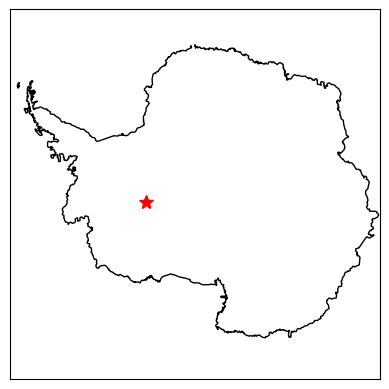

In [4]:
from obspy.clients.fdsn import Client
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

iris = Client('IRIS')
netcode = 'YT'
stacode = 'ST01'

## get station information
inv = iris.get_stations(network=netcode, station=stacode, level='station')

## get the station coordinates
stla = inv[0][0].latitude
stlo = inv[0][0].longitude

## plot the station location on map
m = Basemap(projection='spstere', boundinglat=-65, lon_0=180, resolution='l')
m.drawcoastlines()
m.plot(stlo, stla, 'r*', markersize=10, latlon=True)
plt.show()

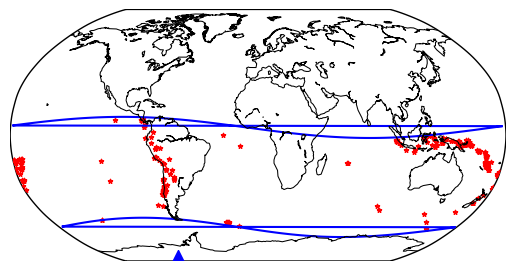

In [5]:
## get the event metadata from the IRIS server
cat = iris.get_events(starttime=inv[0][0].start_date, endtime=inv[0][0].end_date, 
    latitude=stla, longitude=stlo, minradius=30.0, maxradius=95.0, minmagnitude=6.0)

## plot the event location on a global map
m = Basemap(projection='robin', lon_0=0, resolution='c')
m.drawcoastlines(linewidth=.75)
## plot event location by red stars
m.scatter([_.preferred_origin().longitude for _ in cat], [_.preferred_origin().latitude for _ in cat], 
    latlon=True, s=10, c='r', marker='*')
## plot the station location by blue triangle
m.plot(stlo, stla, 'b^', markersize=10, latlon=True)
## plot the tissots showing the distance from the station
m.tissot(stlo, stla, 30, 100, facecolor='none', edgecolor='b', linewidth=1.5)
m.tissot(stlo, stla, 95, 100, facecolor='none', edgecolor='b', linewidth=1.5)

plt.show()

In [ ]:
## for each event, predict the arrival time of the P wave
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth
from obspy.clients.fdsn.client import FDSNNoDataException
taup_model = TauPyModel(model='ak135')

# headers = []
bulk = []
for event in cat:
    origin = event.preferred_origin()
    dist, az, baz = gps2dist_azimuth(origin.latitude, origin.longitude, stla, stlo)
    dist = dist / 1000.0 # distance in km
    gcarc = dist / 111.195 # distance in degrees

    p_arv = taup_model.get_travel_times(source_depth_in_km=origin.depth/1000.0,
        distance_in_degree=gcarc, phase_list=['P'])[0]
    p_arv_time = origin.time + p_arv.time

    bulk.append((netcode, stacode, '', 'BH?', p_arv_time-10, p_arv_time+50))
    
## get the waveform data
# bulk = [(_['network'], _['station'], '*', 'BH?', _['starttime'], _['endtime']) for _ in headers]
# for _ in bulk: print(_)
dstream = iris.get_waveforms_bulk(bulk, threaded=True, minimumlength=55)

In [ ]:
## assocating the data with the event

: 

: 

#### Data processing and results

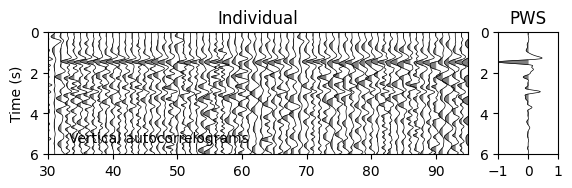

In [13]:
import matplotlib.pyplot as plt
from obspy import read
from obspy.core import Stream
from glob import glob

if __name__ == '__main__':
    ## fixed parameter
    freq_width = 0.5
    order = 1
    
    ## MAIN PROCESSING FOR VERTICAL AUTOCORRELOGRAMS
    auto_stream = Stream()
    for tr in dstream.select(component='Z'):
        tr.detrend('linear')
        auto = compute_auto(tr, freq_width, 2400)
        auto_stream.append(auto)
    stack = data_stack(auto_stream, order)
    time = np.arange(stack.stats.npts) * stack.stats.delta
    
    ## PLOTTING
    fig = plt.figure(figsize=(6, 3.5))
    ax1 = fig.add_axes([0.1, 0.57, 0.7, 0.35])
    ax1.set_xlim(30, 95)
    ax1.set_ylim(6, 0)
    ax1.set_ylabel('Time (s)')
    ax1.annotate('Vertical autocorrelograms', xy=(0.05, 0.1), xycoords='axes fraction')
    ax1.set_title('Individual')
    epi_dist = 0
    for auto in auto_stream:
        auto.data /= np.max(np.abs(auto.data))
        # epi_dist = auto.stats.sac.gcarc
        ax1.plot(auto.data + epi_dist, time, lw=0.5, color='black')
        ax1.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5, 
                          color='gray', where=(auto.data < 0))
        epi_dist += 1
    
    ax2 = fig.add_axes([0.85, 0.57, 0.1, 0.35])
    ax2.set_ylim(6, 0)
    ax2.set_xlim(-1, 1)
    ax2.set_title('PWS')
    stack.data /= np.max(np.abs(stack.data))
    ax2.plot(stack.data, time, lw=0.5, color='black')
    ax2.fill_betweenx(time, 0, stack.data, lw=0.5, 
                          color='gray', where=(stack.data < 0))
    
    # ## MAIN PROCESSING FOR RADIAL AUTOCORRELOGRAMS
    # auto_stream = Stream()
    # for fname in glob('ST01/*BHR*.SAC'):
    #     tr = read(fname, format='SAC')[0]
    #     tr.detrend('linear')
    #     tr.resample(40)
        
    #     auto = compute_auto(tr, freq_width)
    #     auto_stream.append(auto)
    # stack = data_stack(auto_stream, order)
    # time = np.arange(stack.stats.npts) * stack.stats.delta
    
    # ## PLOTTING
    # ax1 = fig.add_axes([0.1, 0.12, 0.7, 0.35])
    # ax1.set_xlim(30, 95)
    # ax1.set_ylim(6, 0)
    # ax1.set_ylabel('Time (s)')
    # ax1.set_xlabel('Epicentral distance ($^\circ$)')
    # ax1.annotate('Radial autocorrelograms', xy=(0.05, 0.1), xycoords='axes fraction')
    # for auto in auto_stream:
    #     auto.data /= np.max(np.abs(auto.data))
    #     epi_dist = auto.stats.sac.gcarc
    #     ax1.plot(auto.data + epi_dist, time, lw=0.5, color='black')
    #     ax1.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5, 
    #                       color='gray', where=(auto.data < 0))
    
    # ax2 = fig.add_axes([0.85, 0.12, 0.1, 0.35])
    # ax2.set_ylim(6, 0)
    # ax2.set_xlim(-1, 1)
    # stack.data /= np.max(np.abs(stack.data))
    # ax2.plot(stack.data, time, lw=0.5, color='black')
    # ax2.fill_betweenx(time, 0, stack.data, lw=0.5, 
    #                       color='gray', where=(stack.data < 0))
    
    plt.show()
    